In [142]:
import psycopg2

In [144]:
con = psycopg2.connect(user = "postgres",
                       password = "",
                       host = "127.0.0.1",
                       port = "5432",
                       database = "adj_noun_pairs")

try:
    cursor = con.cursor();
except (Exception, psycopg2.Error) as error:
    print("Error in Connection",error)

In [145]:
try:
    cursor.execute("SELECT * FROM all_pairs_counts")
    pairs = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [146]:
print("Number of pairs:", len(pairs), "\nFirst pair and count:", pairs[0])

Number of pairs: 3070458 
First pair and count: ('eelmine', 'aasta', 53250)


### Number of pairs per threshold

Choosing thresholds and counting how many pairs are left if that threshold is applied. So for example if threshold is 10, then all pairs that occurred 10 times or less in the used texts are dropped and the number of pairs remaining is counted.

In [147]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

#### Threshold from 0 to 100

In [148]:
number_of_pairs = defaultdict(int)

for i in range(100):
    new_pairs = [pair for pair in pairs if pair[2] > i]
    number_of_pairs[i] = len(new_pairs)

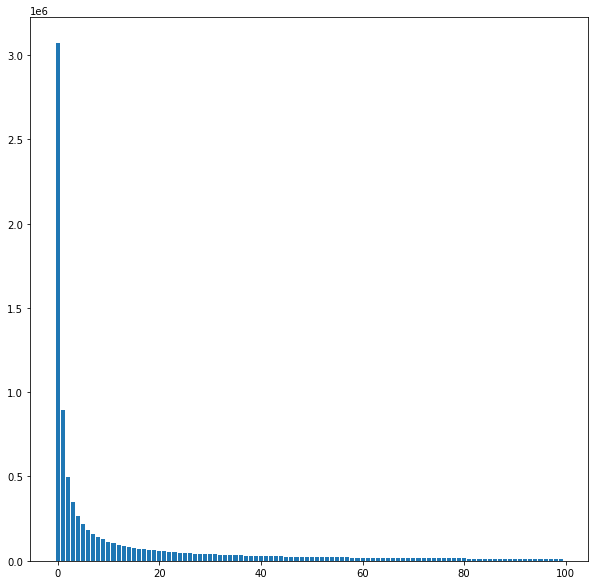

In [23]:
plt.figure(figsize=(10, 10))
plt.bar(*zip(*number_of_pairs.items()))
plt.show()

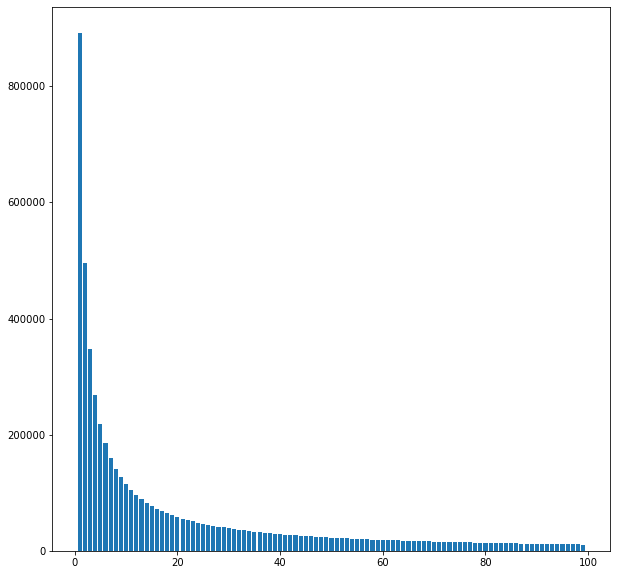

In [25]:
plt.figure(figsize=(10, 10))
plt.bar(*zip(*list(number_of_pairs.items())[1:]))
plt.show()

#### Threshold from 0 to 1000 with a step of 10

In [149]:
number_of_pairs_10 = defaultdict(int)

for i in range(0, 1000, 10):
    new_pairs = [pair for pair in pairs if pair[2] > i]
    number_of_pairs_10[i] = len(new_pairs)

In [60]:
number_of_pairs_10[990]

490

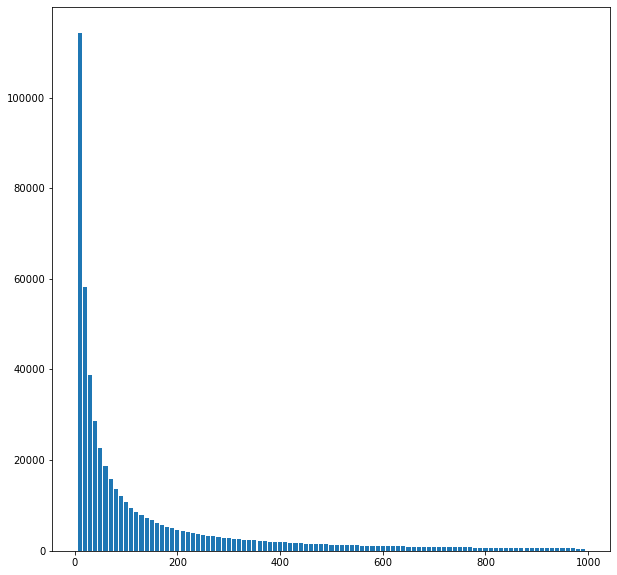

In [59]:
plt.figure(figsize=(10, 10))
plt.bar(*zip(*list(number_of_pairs_10.items())[1:]), width=8)
#plt.xticks(rotation=45)
#plt.setp(cbar.ax.get_xticklabels()[::2], visible=False)
#[label.set_visible(False) for i, label in enumerate(ax.xaxis.get_ticklabels()) if i % 10 != 0]
plt.show()

#### How many times the 100 most popular pairs appeared in the texts

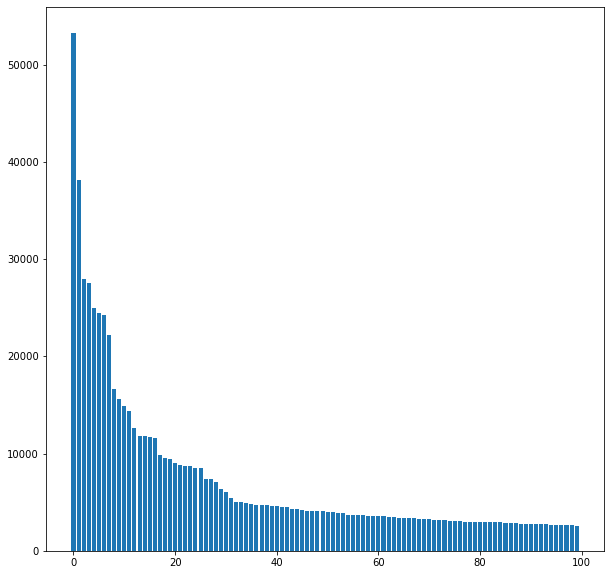

In [61]:
plt.figure(figsize=(10, 10))
plt.bar(range(100), [pair[2] for pair in pairs[:100]])
plt.show()

In [62]:
pairs[99]

('avalik', 'kord', 2599)

In [63]:
pairs[:10]

[('eelmine', 'aasta', 53250),
 ('järgmine', 'aasta', 38107),
 ('viimane', 'aeg', 27915),
 ('käesolev', 'määrus', 27514),
 ('kogu', 'aeg', 24997),
 ('viimane', 'aasta', 24410),
 ('kohalik', 'omavalitsus', 24261),
 ('suur', 'osa', 22165),
 ('suur', 'tänu', 16634),
 ('eelmine', 'nädal', 15648)]

#### Percentage of pairs over threshold

In [150]:
from copy import deepcopy

In [151]:
stat_per_threshold = {}

new_pairs = deepcopy(pairs)

for i in range(pairs[0][2] + 1):
    new_pairs = [pair for pair in new_pairs if pair[2] > i]
    stat_per_threshold[i] = (len(new_pairs), len(new_pairs) / len(pairs) * 100) # saving as number of pairs and percentage of pairs left per threshold, as I'm iterating until all pairs are dropped and may want to use all stats later

In [118]:
for key, value in stat_per_threshold.items():
    if value[1] < 1:
        print(key, value)
        break

38 (30262, 0.9855858637375923)


In [119]:
for key, value in stat_per_threshold.items():
    if value[1] < 0.1:
        print(key, value)
        break

277 (3064, 0.09978967307157434)


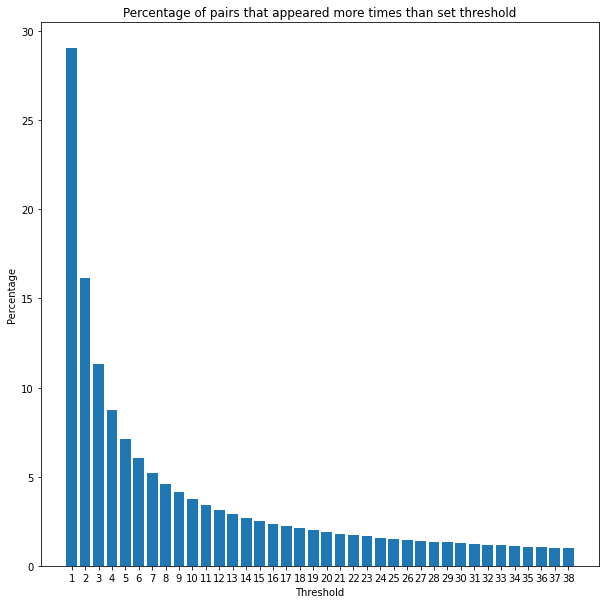

In [101]:
plt.figure(figsize=(10, 10))
plt.bar(list(range(1, 39)), [stat_per_threshold[i][1] for i in range(1, 39)])
plt.title("Percentage of pairs that appeared more times than set threshold")
plt.xlabel("Threshold")
plt.ylabel("Percentage")
plt.xticks(list(range(1, 39)))
plt.show()

### Power law

In [152]:
from plotnine import *
import pandas as pd

In [153]:
stats = [(key, value[0], value[1]) for key, value in stat_per_threshold.items()]

In [154]:
df = pd.DataFrame(stats, columns=['threshold','count' , 'percentage'])
df

,threshold,count,percentage
0,0,3070458,100.000000
1,1,891727,29.042149
2,2,496057,16.155798
3,3,347644,11.322220
4,4,268116,8.732117
...,...,...,...
53246,53246,1,0.000033
53247,53247,1,0.000033
53248,53248,1,0.000033
53249,53249,1,0.000033


In [155]:
df2 = df.drop_duplicates('count')

In [156]:
df2

,threshold,count,percentage
0,0,3070458,100.000000
1,1,891727,29.042149
2,2,496057,16.155798
3,3,347644,11.322220
4,4,268116,8.732117
...,...,...,...
24997,24997,4,0.000130
27514,27514,3,0.000098
27915,27915,2,0.000065
38107,38107,1,0.000033


C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


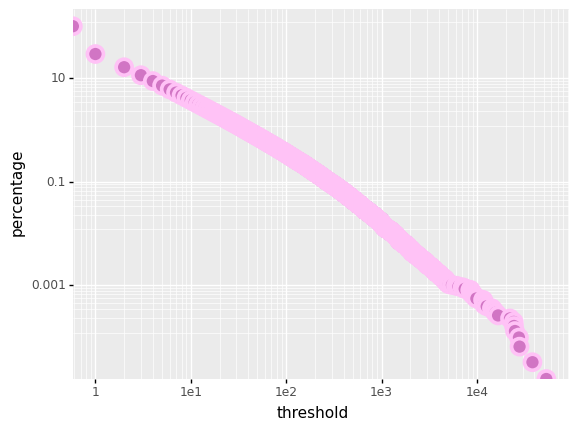

<ggplot: (111293191474)>

In [166]:
fig = (
    ggplot(data=df2) +
    aes(x = 'threshold', y = 'percentage') + 
    geom_point(fill = '#d175c4', 
               size = 5,
               stroke = 1.5,
               colour = '#ffc2f6',
               shape = 'o') +
    scale_x_log10() +
    scale_y_log10()
)
fig

In [167]:
from sklearn.linear_model import LinearRegression

In [186]:
lr = LinearRegression()
lr.fit(np.log10(df2[['threshold']]).drop(df2.tail(1).index).drop(df2.head(1).index), np.log10(df2[['percentage']].drop(df2.tail(1).index).drop(df2.head(1).index)))

C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10


LinearRegression()

In [169]:
print(lr.coef_, lr.intercept_)

[[-1.3648971]] [2.27536039]


C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10


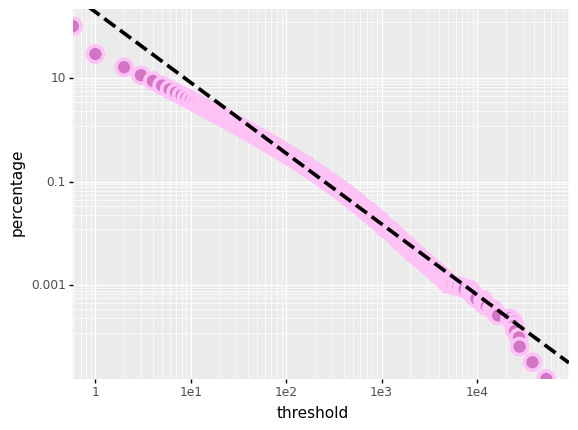

<ggplot: (111293191600)>

In [170]:
fig = fig + geom_abline(intercept = lr.intercept_, slope = lr.coef_[0], color="black", linetype="dashed", size=1.5)
fig

#### Finding differences in predictions

In [193]:
10**np.log10(df2[['percentage']].loc[1][0])

29.042149412237524

In [195]:
predictions = lr.predict(np.log10(df2[['threshold']]).drop(df2.tail(1).index).drop(df2.head(1).index))

C:\Users\Birgit\Anaconda3\envs\py36_estnltk\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10


In [196]:
predicted_percentages = [10**pred for pred in predictions]

In [225]:
indexes = []
idx = 0

for i, row in df2.drop(df2.tail(1).index).drop(df2.head(1).index).iterrows():
    if abs((row['percentage'] - predicted_percentages[idx])[0]) <= 5:
        indexes.append(i)
    idx += 1

In [228]:
new_df = df2.loc[indexes]

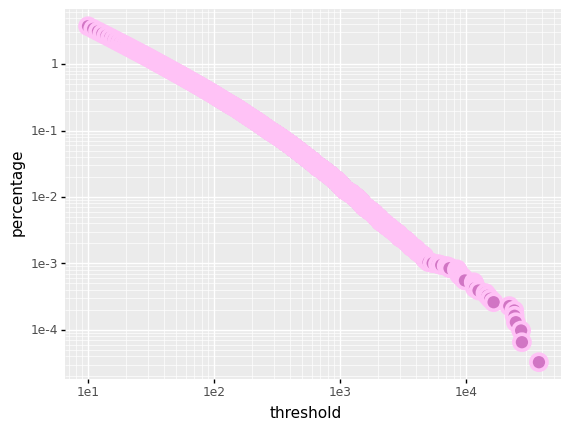

<ggplot: (111293684302)>

In [229]:
fig2 = (
    ggplot(data=new_df) +
    aes(x = 'threshold', y = 'percentage') + 
    geom_point(fill = '#d175c4', 
               size = 5,
               stroke = 1.5,
               colour = '#ffc2f6',
               shape = 'o') +
    scale_x_log10() +
    scale_y_log10()
)
fig2

In [232]:
lr2 = LinearRegression()
lr2.fit(np.log10(new_df[['threshold']]), np.log10(new_df[['percentage']]))

LinearRegression()

In [233]:
print(lr2.coef_, lr2.intercept_)

[[-1.39651069]] [2.36687784]


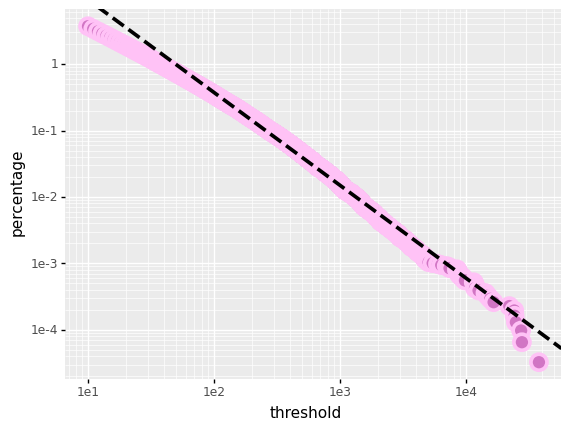

<ggplot: (-9223371925561091559)>

In [234]:
fig2 = fig2 + geom_abline(intercept = lr2.intercept_, slope = lr2.coef_[0], color="black", linetype="dashed", size=1.5)
fig2

### Exploring examples of different threshold

In this section I will look at examples that occurred very few times (ie once, twice etc) and check the texts corresponding to them to see if the pairs are true or false positive. This will help set the final threshold that determines what pairs are used for dividing words into clusters.

In [15]:
import random
import estnltk
from estnltk.storage.postgres import PostgresStorage

In [42]:
storage = PostgresStorage(host="postgres.keeleressursid.ee",
                          dbname="estonian-text-corpora",
                          user="sormusbi",
                          password="", #enter password
                         port=5432,
                         schema="estonian_text_corpora")

INFO:storage.py:42: connecting to host: 'postgres.keeleressursid.ee', port: 5432, dbname: 'estonian-text-corpora', user: 'sormusbi'
INFO:storage.py:58: schema: 'estonian_text_corpora', temporary: False, role: 'sormusbi'


In [43]:
collection = storage['koondkorpus_base_v2']
collection.selected_layers = ['v166_morph_analysis', 'v166_sentences']

DEBUG:pg_operations.py:75: SELECT table_name, pg_size_pretty(pg_total_relation_size('estonian_text_corpora'||'.'||table_name)), obj_description(('estonian_text_corpora'||'.'||table_name)::regclass), S.n_live_tup FROM information_schema.tables LEFT JOIN pg_stat_user_tables S ON S.relname = table_name AND S.schemaname = table_schema WHERE table_schema='estonian_text_corpora' AND table_type='BASE TABLE';
DEBUG:pg_operations.py:75: SELECT table_name, pg_size_pretty(pg_total_relation_size('estonian_text_corpora'||'.'||table_name)), obj_description(('estonian_text_corpora'||'.'||table_name)::regclass), S.n_live_tup FROM information_schema.tables LEFT JOIN pg_stat_user_tables S ON S.relname = table_name AND S.schemaname = table_schema WHERE table_schema='estonian_text_corpora' AND table_type='BASE TABLE';


#### Pairs that occurred only once 

In [6]:
once = [pair for pair in pairs if pair[2] == 1]

In [7]:
len(once)

2178731

In [9]:
once_samples = random.sample(once, 10)

Get ids of the texts these pairs were extracted from, so I could check whether the pair in the text made sense or if it was a false positive.

In [11]:
once_samples[0]

('kuiv', 'uksetihend', 1)

In [12]:
pairs_with_ids = []

for sample in once_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids.append(cursor.fetchone()) # fetchone is sufficient because all of these pairs appeared only once anyway and are thus present only once

In [13]:
pairs_with_ids

[('kuiv', 'uksetihend', 527340, 'artikkel'),
 ('läinud', 'meeleavaldus', 200070, 'artikkel'),
 ('oletatav', 'palgamäär', 288748, 'artikkel'),
 ('üldine', 'elumüra', 184648, 'artikkel'),
 ('tüüpiline', 'enamus', 429896, 'artikkel'),
 ('kunagine', 'kaubakompanii', 2692, 'artikkel'),
 ('ajalooline', 'alibi', 436824, 'artikkel'),
 ('tänane', 'ristiisa', 343723, 'artikkel'),
 ('vanune', 'inff', 678745, 'kommentaarid'),
 ('uus', 'lavakultuur', 4234, 'artikkel')]

In [20]:
sample_texts = []

for pair in pairs_with_ids:
    sample_texts.append(collection[pair[2]])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(527340)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(200070)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(288748)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(184648)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(429896)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(2692)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2

In [36]:
for idx, text in enumerate(sample_texts):
    pair = once_samples[idx]
    noun = pair[1]
    print(pair[0], pair[1])
    
    for sentence in text.v166_sentences:
        for morph in sentence.v166_morph_analysis:
            if morph.lemma[0] == noun:
                print(' '.join(sentence.text))
                break
    print("-"*50)

kuiv uksetihend
Üksiti puhutakse pesuveest kuivaks uksetihendid .
--------------------------------------------------
läinud meeleavaldus
Vene noorukite laamendamiseks üle läinud meeleavaldus USA saatkonna ees pärast Eesti ühinemist Iraagi-vastase koalitsiooniga .
--------------------------------------------------
oletatav palgamäär
" Siis oleks eelmisel koosseisul võimalus sätestada järgmise koosseisu liikmetele ühiskondlikult vastuvõetav palgamäär ja selle muutumise mehhanism , mis ei oleks otseselt sõltuv täitevvõimu otsustest , " tähendab rahandusminister Siim Kallas BNSile .
" Praegu ei oska ta igal juhul öelda , milline võiks oletatav kindel palgamäär olla , mis ehk kunagi tulevikus riigi majanduslikust edust sõltuda võiks .
Haugi sõnul on teoreetiliselt konkreetse palgamäära kinnitamine võimalik , aga sisuliselt vale otsus .
--------------------------------------------------
üldine elumüra
Tuleval nädalavahetusel Tartus peetaval Improvizzi festivalil hakkavad korraldajad Eesti ja

Järeldus: pooled on valepositiivsed (vanune inff, kunagine kaubakompanii, tüüpiline enamus, läinud meeleavaldus, kuiv uksetihend), mis on üsna suur osa, eriti kuna paare, mida leidus tekstides vaid üks kord, oli väga palju (üle 2 miljoni paari), siis kui nii suur osa nendest on valepositiivsed, mõjutab see tulemusi kindlasti kehvasti.

#### Pairs that occurred twice

In [44]:
twice = [pair for pair in pairs if pair[2] == 2]

In [45]:
len(twice)

395670

In [46]:
twice_samples = random.sample(twice, 10)

In [47]:
twice_samples[0]

('kuuluv', 'soojustrass', 2)

In [53]:
pairs_with_ids_2 = []

for sample in twice_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_2.append(cursor.fetchall())

In [54]:
pairs_with_ids_2

[[('kuuluv', 'soojustrass', 420668, 'artikkel'),
  ('kuuluv', 'soojustrass', 366222, 'artikkel')],
 [('plaanitav', 'sulgemine', 486742, 'artikkel'),
  ('plaanitav', 'sulgemine', 68738, 'artikkel')],
 [('ehitatav', 'mudel', 301786, 'artikkel'),
  ('ehitatav', 'mudel', 301887, 'artikkel')],
 [('kohalik', 'pall', 101082, 'artikkel'),
  ('kohalik', 'pall', 458907, 'artikkel')],
 [('individuaalne', 'juhtum', 3235, 'artikkel'),
  ('individuaalne', 'juhtum', 388015, 'tervikteos')],
 [('professionaalne', 'lõhkaja', 6234, 'artikkel'),
  ('professionaalne', 'lõhkaja', 6234, 'artikkel')],
 [('sealne', 'väiketootja', 298009, 'artikkel'),
  ('sealne', 'väiketootja', 365453, 'artikkel')],
 [('vabariiklik', 'tööinspektsioon', 445483, 'artikkel'),
  ('vabariiklik', 'tööinspektsioon', 704489, 'stenogramm')],
 [('pakkuv', 'alune', 287177, 'artikkel'),
  ('pakkuv', 'alune', 81289, 'artikkel')],
 [('ametlik', 'teovõime', 59179, 'artikkel'),
  ('ametlik', 'teovõime', 386318, 'artikkel')]]

In [55]:
sample_texts_2 = []

for pair in pairs_with_ids_2:
    sample_texts_2.append([collection[pair[0][2]], collection[pair[1][2]]])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(420668)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(366222)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(486742)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(68738)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(301786)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(301887)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

In [58]:
for idx, texts in enumerate(sample_texts_2):
    pair = twice_samples[idx]
    noun = pair[1]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            for morph in sentence.v166_morph_analysis:
                if morph.lemma[0] == noun:
                    print(' '.join(sentence.text))
                    break
    print("-"*50)

kuuluv soojustrass 

Text nr 1
Endise Tallinna-nimelise hotelli laiendamine ja renoveerimine on takerdunud soojustrassi ja segase seadusandluse taha .
Hotellitöödel on aga tekkinud segadused kinnistut läbiva Tallinna Soojusele kuuluva soojustrassiga , mistõttu linnaplaneerimisamet peatas osaliselt ehitustööd .
Tallinna hotelli renoveerimisel puhkes soojustrassi pärast tüli , kuna renoveerija OÜ Wicom ühendas lahti kinnistut läbiva soojustrassi .

Text nr 2
Tallinna linnavalitsus otsustas eilsel istungil võtta vastu tänavu juba teine lisaeelarve , millega suunatakse soojustrasside müügist saadav 26,4 miljonit krooni tänavate remondiks .
Valisime teise tee ning linnale kuuluvate soojustrasside näol me vajalikud lisavahendid ka leidsime .
Soojustrasside müümine Tallinna Soojusele ei muuda linlaste jaoks soojatarbimise osas mitte midagi , küll aga muutub linna liiklus selle tulemusena elanikele tunduvalt mugavamaks ja turvalisemaks .
--------------------------------------------------
plaan

Järeldus: valepositiivsed on kuuluv soojustrass, kohalik pall, pakkuv alune

ehitatav mudel - mitte otseselt valepositiivne, kuid leidus tegelikkuses vaid kord, sest kaks erinevat teksti langesid kokku (sama tekstiallikas, kuid erinev rubriik) <br>
ametlik teovõime - sama, mis eelmine (tundus olevat sama tekst, kuid erinevatest allikatest - üks Eesti Ekspressi, teine Eesti Päevalehe artikkel)

Samuti üsna väike hulk päriselt positiivseid

##### Examples of two texts that were pretty much the same and caused a pair (ametlik teovõime) to appear twice because of it

In [128]:
collection[301786]

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(301786)])])


Text(text='Antti Oolo\n\nPresidendi ametiauto riigihanke konkursil lubasid kindlasti osaleda Audide , Mercedeste , Volvode ja BMW-de maaletoojad ; autofirmade esindajad kinnitasid , et teevad presidendile hinnaalandust .\n\nReval Auto tegevjuhi Aivar Toompere sõnul pakub nende firma presidendile pikendatud kerega luksusautot Audi A8L .\n\nMercedeseid müüva firma Silberauto pressiesindaja Üllar Born ütles , et praegu pole firmas otsustatud , millist Mercedese mudelit nad presidendile pakuvad . Traditsioonide kohaselt on Eesti president seni sõitnud Mercedesega , lausus Born .\n\nBMW-d esindava firma United Motors müügidirektori Toomas Pärna sõnul pole nad täpselt otsustanud , millist autot presidendile pakkuda , kuid konkursil osaleb firma igal juhul .\n\nUnited Motors pakub presidendile vanemat 7-seeria BMW pikendatud kerega mudelit , kuna uusima mudeli pikendatud kerega variant valmib alles tuleva aasta märtsiks .\n\nVolvosid müüva Info-Auto turundusdirektori Tiit Lillipuu sõnul pakuvad nemad presidendile eritellimusel pikendatud kerega ehitatavat mudelit Volvo S80 .\n\nPresidendi ametiauto riigihanke konkursil osalemise tähtaeg on 7. jaanuaril kell 11.')

In [129]:
collection[301887]

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(301887)])])


Text(text='Antti Oolo\n\nPresidendi ametiauto riigihanke konkursil lubasid kindlasti osaleda Audide , Mercedeste , Volvode ja BMW-de maaletoojad ; autofirmade esindajad kinnitasid , et teevad presidendile hinnaalandust .\n\nReval Auto tegevjuhi Aivar Toompere sõnul pakub nende firma presidendile pikendatud kerega luksusautot Audi A8L .\n\nMercedeseid müüva firma Silberauto pressiesindaja Üllar Born ütles , et praegu pole firmas otsustatud , millist Mercedese mudelit nad presidendile pakuvad . " Traditsioonide kohaselt on Eesti president seni sõitnud Mercedesega , " lausus Born .\n\nBMW-d esindava firma United Motors müügidirektori Toomas Pärna sõnul pole nad täpselt otsustanud , millist autot presidendile pakkuda , kuid konkursil osaleb firma igal juhul .\n\nUnited Motors pakub presidendile vanemat 7-seeria BMW pikendatud kerega mudelit , kuna uusima mudeli pikendatud kerega variant valmib alles tuleva aasta märtsiks .\n\nVolvosid müüva Info-Auto turundusdirektori Tiit Lillipuu sõnul pakuvad nemad presidendile eritellimusel pikendatud kerega ehitatavat mudelit Volvo S80 .\n\nPresidendi ametiauto riigihanke konkursil osalemise tähtaeg on 7. jaanuaril kell 11.')

#### Pairs that occurred three times

In [66]:
three = [pair for pair in pairs if pair[2] == 3]

In [67]:
len(three)

148413

In [68]:
three_samples = random.sample(three, 10)

In [69]:
three_samples[0]

('vapper', 'sõna', 3)

In [70]:
pairs_with_ids_3 = []

for sample in three_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_3.append(cursor.fetchall())

In [71]:
pairs_with_ids_3

[[('vapper', 'sõna', 11871, 'artikkel'),
  ('vapper', 'sõna', 406418, 'artikkel'),
  ('vapper', 'sõna', 667520, 'artikkel')],
 [('tähistav', 'monument', 84780, 'artikkel'),
  ('tähistav', 'monument', 483267, 'artikkel'),
  ('tähistav', 'monument', 228686, 'artikkel')],
 [('25aastane', 'õpetaja', 581898, 'artikkel'),
  ('25aastane', 'õpetaja', 569721, 'artikkel'),
  ('25aastane', 'õpetaja', 488547, 'artikkel')],
 [('edukas', 'äriühing', 698380, 'stenogramm'),
  ('edukas', 'äriühing', 251544, 'artikkel'),
  ('edukas', 'äriühing', 379451, 'dissertatsioon')],
 [('märkimisväärne', 'teade', 13168, 'artikkel'),
  ('märkimisväärne', 'teade', 411629, 'artikkel'),
  ('märkimisväärne', 'teade', 447554, 'artikkel')],
 [('juhtiv', 'maksukonsultant', 173684, 'artikkel'),
  ('juhtiv', 'maksukonsultant', 379379, 'dissertatsioon'),
  ('juhtiv', 'maksukonsultant', 333609, 'artikkel')],
 [('napp', 'sissekanne', 311972, 'artikkel'),
  ('napp', 'sissekanne', 383367, 'artikkel'),
  ('napp', 'sissekanne', 38

In [72]:
sample_texts_3 = []

for pair in pairs_with_ids_3:
    sample_texts_3.append([collection[pair[i][2]] for i in range(3)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(11871)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(406418)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(667520)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(84780)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(483267)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(228686)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2

In [98]:
for idx, texts in enumerate(sample_texts_3):
    pair = three_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
            #for morph in sentence.v166_morph_analysis:
                #if morph.lemma[0] == noun:
                #    print(' '.join(sentence.text))
                #    break
    print("-"*50)

vapper sõna 

Text nr 1
Kõigist neist vapratest sõ-nadest hoolimata on Clinto-ni mõjuvõim Washingtonis vaatlejate hinnangul viima-sel ajal märgatavalt kahane-nud .

Text nr 2
Maailma jalgpalliliidu peasekretärile Joseph Blatterile teatati Tallinnast , et mäng toimub 9. oktoobril kas eestlaste poolt määratud ajal või ei toimu üldse ( ! ) , sama vaprad sõnad lasti lendu Eesti pressis .

Text nr 3
Lutvei sõnul olid vaprad tüdrukud suutnud ujuda teisele kaldale , kuid tagasi ujudes nende jõud rauges .
--------------------------------------------------
tähistav monument 

Text nr 1
Planeeringus on ette nähtud Viru hotell 2 ehitus praeguse hotellipurskkaevu kohale ja Eesti teede nullpunkti tähistav monument liiklusristi keskele .

Text nr 2
See seisab seal justkui ühe ajastu lõppu tähistav monument .

Text nr 3
Linnavolinik Arvo Aun tellis oma initsiatiivil skulptor Rinaldo Veeberilt linna nullpunkti tähistava monumendi maksumusega 200 000 - 300 000 krooni .
---------------------------------

Järeldus: valepositiivsed on haige lennuk

vapper sõna - valepositiivne 1 juhul 3-st <br>
märkimisväärne teade - kaks lauset olid identsed seega ilmselt kaks teksti langesid kokku (vt analooge 2 esinemiskorraga näidete juures), seega tegelt esines 2 korda <br>
napp sissekanne - sama, mis eelmine <br>
kerge föönitamine - sama, mis eelmine

Üks paar oli täielikult valepositiivne, ühel paaril oli üks esinemiskord valepositiivne ning kolme paari puhul oli näha, et ühelgi juhul ei olnud tegu valepositiivse paariga, kuid kuna kaks teksti langesid kokku, leidus neid vaid kahes erinevas tekstis. Viis paari olid seega (true) positiivsed kolmel korral ning kaheksa paari olid üleüldiselt korrektsed.

#### Pairs that occurred four times

In [99]:
four = [pair for pair in pairs if pair[2] == 4]

In [100]:
len(four)

79528

In [101]:
four_samples = random.sample(four, 10)

In [102]:
four_samples[0]

('ebaseaduslik', 'rühmitus', 4)

In [103]:
pairs_with_ids_4 = []

for sample in four_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_4.append(cursor.fetchall())

In [104]:
pairs_with_ids_4

[[('ebaseaduslik', 'rühmitus', 210582, 'artikkel'),
  ('ebaseaduslik', 'rühmitus', 338898, 'artikkel'),
  ('ebaseaduslik', 'rühmitus', 158881, 'artikkel'),
  ('ebaseaduslik', 'rühmitus', 220934, 'artikkel')],
 [('ühiskondlik', 'osa', 41661, 'artikkel'),
  ('ühiskondlik', 'osa', 193038, 'artikkel'),
  ('ühiskondlik', 'osa', 486510, 'artikkel'),
  ('ühiskondlik', 'osa', 370272, 'tervikteos')],
 [('intelligentne', 'molekul', 240773, 'artikkel'),
  ('intelligentne', 'molekul', 90247, 'artikkel'),
  ('intelligentne', 'molekul', 157763, 'artikkel'),
  ('intelligentne', 'molekul', 692143, 'teema')],
 [('mässumeelne', 'poeg', 554377, 'artikkel'),
  ('mässumeelne', 'poeg', 288802, 'artikkel'),
  ('mässumeelne', 'poeg', 479321, 'artikkel'),
  ('mässumeelne', 'poeg', 649231, 'artikkel')],
 [('maksev', 'laserplaadikogu', 507638, 'artikkel'),
  ('maksev', 'laserplaadikogu', 214042, 'artikkel'),
  ('maksev', 'laserplaadikogu', 273984, 'artikkel'),
  ('maksev', 'laserplaadikogu', 507618, 'artikkel')]

In [105]:
sample_texts_4 = []

for pair in pairs_with_ids_4:
    sample_texts_4.append([collection[pair[i][2]] for i in range(4)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(210582)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(338898)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(158881)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(220934)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(41661)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(193038)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

In [106]:
for idx, texts in enumerate(sample_texts_4):
    pair = four_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
    print("-"*50)

ebaseaduslik rühmitus 

Text nr 1
Politsei teatas , et ebaseadusliku rühmituse Jagrata Muslim Janata Bangladesh juht Bangla Bhai vahistati koos tema abikaasa ja kahe kaasosalisega Mymensinghi piirkonnas asunud peidikust .

Text nr 2
Pakistani valitsuse teatel on Ahmed ebaseadusliku rühmituse Jaish-e-Mohammedi liige .

Text nr 3
Inguššias on kinni peetud kaks ebaseadusliku rühmituse liiget , keda kahtlustatakse " Nevski Ekspressi " kiirrongi õhku laskmises Novgorodi oblastis 13. augustil .

Text nr 4
Peamiselt kurdi elanikkonnaga Vanis on kasvanud pinged pärast seda , kui sealne riigiprokurör süüdistas Türgi maavägede juhatajat ametikoha kuritarvitamises ja ebaseadusliku rühmituse rajamises , mis õhutab vaenu riigi kaguosas , et takistada sellega Ankara liitumist Euroopa Liiduga .
--------------------------------------------------
ühiskondlik osa 

Text nr 1
Perekondlikele lisanduvad ühiskondlikud osad , mis tulenevad haridusest , positsioonist , elukutsest jne .

Text nr 2
Oluline osa 

Järeldus: valepositiivsed on maksev laserplaadikogu (tegelt summa - näiteks miljon krooni maksev), iseloomulik ajastu, pikk paekivi (tegelt pikk paekivist {nimisõna} enamasti)

ühiskondlik osa - 1 valepositiivne 4-st <br>
maksev laserplaadikogu - 3 teksti 4-st on korduvad (lause oli vähemalt sama)

Põhimõtteliselt kolm valepositiivset

#### Pairs that occurred five times

In [107]:
five = [pair for pair in pairs if pair[2] == 5]

In [108]:
len(five)

49189

In [109]:
five_samples = random.sample(five, 10)

In [110]:
five_samples[0]

('seltskondlik', 'laul', 5)

In [111]:
pairs_with_ids_5 = []

for sample in five_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_5.append(cursor.fetchall())

In [112]:
pairs_with_ids_5

[[('seltskondlik', 'laul', 268700, 'artikkel'),
  ('seltskondlik', 'laul', 94613, 'artikkel'),
  ('seltskondlik', 'laul', 268972, 'artikkel'),
  ('seltskondlik', 'laul', 461024, 'artikkel'),
  ('seltskondlik', 'laul', 648527, 'artikkel')],
 [('kaitsev', 'liikmesriik', 379451, 'dissertatsioon'),
  ('kaitsev', 'liikmesriik', 379451, 'dissertatsioon'),
  ('kaitsev', 'liikmesriik', 379451, 'dissertatsioon'),
  ('kaitsev', 'liikmesriik', 379451, 'dissertatsioon'),
  ('kaitsev', 'liikmesriik', 379451, 'dissertatsioon')],
 [('viidatud', 'juht', 640882, 'seadus'),
  ('viidatud', 'juht', 667286, 'seadus'),
  ('viidatud', 'juht', 643869, 'seadus'),
  ('viidatud', 'juht', 700468, 'seadus'),
  ('viidatud', 'juht', 700468, 'seadus')],
 [('olnud', 'sunniit', 391270, 'artikkel'),
  ('olnud', 'sunniit', 314213, 'artikkel'),
  ('olnud', 'sunniit', 155408, 'artikkel'),
  ('olnud', 'sunniit', 338519, 'artikkel'),
  ('olnud', 'sunniit', 531631, 'artikkel')],
 [('iganädalane', 'raadiokõne', 487286, 'artikk

In [113]:
sample_texts_5 = []

for pair in pairs_with_ids_5:
    sample_texts_5.append([collection[pair[i][2]] for i in range(5)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(268700)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(94613)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(268972)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(461024)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(648527)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(379451)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

In [114]:
for idx, texts in enumerate(sample_texts_5):
    pair = five_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
    print("-"*50)

seltskondlik laul 

Text nr 1
" See on üks moodus , kuidas rahvas panna seltskondlikke laule laulma , muidu on ühislaulmise traditsioon kadumas , sest igal pool käib tümps .

Text nr 2
Iga oma mänguoskuse demonstreerija saab auhinnaks õlut , repertuaaris on lihtsad seltskondlikud laulud , " rääkis pikniku korraldaja Kerli Albin .

Text nr 3
" See on üks moodus , kuidas rahvas panna seltskondlikke laule laulma , muidu on ühislaulmise traditsioon kadumas , sest igal pool käib tümps .

Text nr 4
Oleks tore , kui leiaks ka mõned lauluraamatud , kus nii isamaalised kui ka seltskondlikud laulud sees .

Text nr 5
Tema isamaaliste laulude tsükkel oli peas vanal ja noorel , neid lauldi segamini kõige tuntumate seltskondlike lauludega .
--------------------------------------------------
kaitsev liikmesriik 

Text nr 1
Töötajate õiguslikku seisundit tööandja tegevuse ümberkorraldamisel reguleerivad direktiivid 98 / 59 / EÜ " Kollektiivseid vallandamisi käsitlevate liikmesriikide seaduste ühtlusta

97 Direktiivid 89 / 391 / EMÜ " Töötervishoiu ja - ohutuse täiustamise kohta tööl " ( EÜT L 183 , 29.06.1989 lk 1 - 8 ) , 94 / 45 / EMÜ " Euroopa Töönõukogu asutamise või töötajate teavitamise ja nendega konsulteerimise protseduuri loomise kohta kogu ühenduse ulatuses tegutsevates äriühingutes või kontsernides " ( EÜT L 254 , 30.09.1994 , lk 64 - 72 ) , 98 / 59 / EÜ " Kollektiivseid vallandamisi käsitlevate liikmesriikide seaduste ühtlustamise kohta " ( EÜT L 225 , 12.08.1998 , lk 16 - 21 ) , 2001 / 23 / EÜ " Äriühingute , ettevõtete või äriühingute või ettevõtete osade üleminekul töötajate õigusi kaitsvate liikmesriikide seaduste ühtlustamise kohta " ( EÜT L 82 , 22.03.2001 , lk 16 - 20 ) .

Text nr 4
Töötajate õiguslikku seisundit tööandja tegevuse ümberkorraldamisel reguleerivad direktiivid 98 / 59 / EÜ " Kollektiivseid vallandamisi käsitlevate liikmesriikide seaduste ühtlustamise kohta " , 2001 / 23 / EÜ " Äriühingute , ettevõtete või äriühingute või ettevõtete osade üleminekul töö

Rakenduste alal on ühist huvi pakkuvad projektid järgmised .
Need on üldteenused , kaugõppe ja - koolituse ning kultuuripärandiga seotud ühist huvi pakkuvad rakendused , väikestele ja keskmise suurusega ettevõtetele pakutavad teenused ning transpordi- , keskkonna- ja tervishoiutelemaatika .

Text nr 3
7 ) asutamislepingu artikliga 129c on ette nähtud , et ühendus sätestab suunised , mis hõlmavad üleeuroopaliste võrkude valdkonnas kavandatud eesmärke , prioriteete ja üldmeetmeid ; nendes suunistes tuleb kindlaks määrata ühist huvi pakkuvad projektid ; telekommunikatsiooni infrastruktuuride valdkonnas hõlmavad üle-euroopalised võrgud kõnealuste võrkude kolm tasandit : rakendused , üldteenused ja baasvõrgud ;
8 ) infoühiskonna areng ei ole võimalik ilma kättesaadavate rakendusteta , eelkõige vajatakse ühishuvidele vastavaid rakendusi , mis vastaksid võimalikult suurel määral kasutajate vajadustele ja võtaksid vajaduse korral arvesse ka vanurite ja puuetega inimeste vajadusi ; seega on rak

Kõik väljavalitud katsetingimused peavad vastama I tüübi katsetuses kasutatava tavapärase sõidu tingimustele .
--------------------------------------------------
vaheline rahukõnelus 

Text nr 1
Ei Ahtisaari ega Schröder soostunud ajakirjanikele üt-lema , kas ja millal Ahtisaari sõidab Belgradi vahendama Jugoslaavia ja lääneriikide vahelisi rahukõnelusi .

Text nr 2
Iisraeli ja Süüria vahelised rahukõnelused Golani kõrgendike üle lõppesid üleeile edutult , kuid osapooled lubasid taas kohtuda 19. jaanuaril .

Text nr 3
Eile aktiviseerusid Marylandis jätkuvad Iisraeli ja Palestiina liidrite vahelised rahukõnelused veelgi .

Text nr 4
Arafati Moskva-visiidi eesmärk on kaasata Venemaa USA , Iisraeli ja Palestiina vahelistesse rahukõnelustesse .

Text nr 5
On ju kuulus kirjamees isegi tunnistanud , et on salaja osalenud Colombia valitsuse ja geriljade vahelistel rahukõnelustel .
--------------------------------------------------
tegelev poliitik 

Text nr 1
Et kanaliseerida sõjaväelaste loo

Järeldus: valepositiivsed on olnud sunniit, vaheline rahukõnelus; pakkuv rakendus - huvi pakkuv rakendus?; tegelev poliitik - nt julgeolekuküsimustega tegelev poliitik

sõna juht kui juhtum

viidatud juht ja pakkuv rakendus - spetsiifilised, ühes tekstis mitu korda

#### Pairs that occurred ten times

In [115]:
ten = [pair for pair in pairs if pair[2] == 10]

In [121]:
len(ten)

12231

In [122]:
ten_samples = random.sample(ten, 10)

In [123]:
ten_samples[0]

('ladinakeelne', 'kiri', 10)

In [124]:
pairs_with_ids_10 = []

for sample in ten_samples:
    cursor.execute(f"SELECT * FROM all_pairs WHERE noun = '{sample[1]}' AND adjective = '{sample[0]}'")
    pairs_with_ids_10.append(cursor.fetchall())

In [125]:
pairs_with_ids_10

[[('ladinakeelne', 'kiri', 343954, 'artikkel'),
  ('ladinakeelne', 'kiri', 448001, 'artikkel'),
  ('ladinakeelne', 'kiri', 450312, 'artikkel'),
  ('ladinakeelne', 'kiri', 660350, 'stenogramm'),
  ('ladinakeelne', 'kiri', 691278, 'artikkel'),
  ('ladinakeelne', 'kiri', 11715, 'artikkel'),
  ('ladinakeelne', 'kiri', 245156, 'artikkel'),
  ('ladinakeelne', 'kiri', 363732, 'dissertatsioon'),
  ('ladinakeelne', 'kiri', 374468, 'artikkel'),
  ('ladinakeelne', 'kiri', 388048, 'tervikteos')],
 [('kordumatu', 'võlu', 403122, 'tervikteos'),
  ('kordumatu', 'võlu', 47748, 'artikkel'),
  ('kordumatu', 'võlu', 376244, 'tervikteos'),
  ('kordumatu', 'võlu', 187033, 'artikkel'),
  ('kordumatu', 'võlu', 373229, 'artikkel'),
  ('kordumatu', 'võlu', 405229, 'tervikteos'),
  ('kordumatu', 'võlu', 505858, 'artikkel'),
  ('kordumatu', 'võlu', 494048, 'artikkel'),
  ('kordumatu', 'võlu', 493345, 'artikkel'),
  ('kordumatu', 'võlu', 523571, 'artikkel')],
 [('suur', 'ootusärevus', 546, 'artikkel'),
  ('suur',

In [126]:
sample_texts_10 = []

for pair in pairs_with_ids_10:
    sample_texts_10.append([collection[pair[i][2]] for i in range(10)])

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(343954)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(448001)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(450312)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(660350)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(691278)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(11715)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v

Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(456491)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(544822)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(697878)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(652378)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(231254)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_v2')]), SQL('.id = '), Literal(231254)])])
Composed([Composed([Composed([Identifier('estonian_text_corpora'), SQL('.'), Identifier('koondkorpus_base_

In [127]:
for idx, texts in enumerate(sample_texts_10):
    pair = ten_samples[idx]
    print(pair[0], pair[1], "")
    
    for i, text in enumerate(texts):
        print("\nText nr", i + 1)
        for sentence in text.v166_sentences:
            lems = [lem[0] for lem in sentence.v166_morph_analysis.lemma]
            if pair[0] in lems and pair[1] in lems:
                print(' '.join(sentence.text))
    print("-"*50)

ladinakeelne kiri 

Text nr 1
Maalingute põhiskeem on enamikul nõudel sama : ülaosas kahe joontevööndi vahel näeme ladinakeelset kirja või ketti meenutavat ornamenti ja selle all põhikujundeid , mida ümbritsevad suurte lehtedega taimed , sageli esineb ka sambaid .

Text nr 2
Osal peekritest on ülaservas ladinakeelsed kirjad .

Text nr 3
Oma tänu prof Morgensternile põlistas Ülikool 1851. a Toomele püstitatud obeliskiga , millel on ladinakeelne kiri Area Morgensterniana .

Text nr 4
Seetõttu ma pakun seekord asendada see sõnaga “ Eesti ” , juhtides tähelepanu sellele , et siiani on ordenitel peal ainult ladinakeelsed kirjad .

Text nr 5
Jon Voighti tütart Angelina Jolied Stone see-eest kiidab , peamiselt tänu näitlejatari kõhtu ehtivale tätoveeringule - nimelt on see ladinakeelne kiri , mis väidab : " See , mis mind toidab , mu ka hävitab " ning Stonei arvates näitab see äärmist arukust .

Text nr 6
Peenest lõuendist lina kõrval oli omaaegse Torino peapiiskopi Julius Cesari ladinakeelne

Oma päevad veetis Zilvio Cordela juures , ehkki lossis oleks teisedki tema tohterdamist vajanud , lubas kuningas teda ära ainult väga erilistel juhtudel .

Text nr 7
Ta lisas , et täiesti uus on kaitseväelase pidulik vormiriietus , mida kasutatakse vaid erilistel juhtudel ja mis põhineb fraki lõikel .

Text nr 8
Ent praegusel juhul pole erilist kahtlust , et Venemaa võtab Liibüa pakkumise vastu ning hakkab Tadžura tuumauurimiskeskust moderniseerima .

Text nr 9
« eriliseks juhuks » .

Text nr 10
2 ) kokkuleppe puudumisel asja omaduste kohta ei sobi asi teatud eriliseks otstarbeks , milleks ostja seda vajab ja mida müüja lepingu sõlmimise ajal teadis või pidi teadma , kui ostja võis mõistlikult tugineda müüja erialastele oskustele või teadmistele , muul juhul aga otstarbeks , milleks seda liiki asju tavaliselt kasutatakse ;
Võimalik aga sel juhul on tegu väga erilise juhuga ja tõenäoliselt võimatu oleks leida litsentsi mis ei kehti meil , ühes odavaimas regioonis ( v . a . Venemaa ) .
-


Text nr 2
" Eesti Päevaleht on väheseid lehti , mida ma loen .

Text nr 3
Nüüd avaldavad järjejutte vähesed lehed .

Text nr 4
Vaid suuremaid portaale ninig väheseid lehti näeb Netscape brauseriga , kuid ka siis pole tulemus sama , mis IE-ga .

Text nr 5
Nüüd on aga pääsenud saadiku märkused mitmetele internetilehekülgedele , ärgitades väheseid sõltumatuid lehti trükkima omalt poolt Alijevit kritiseerivaid artikleid .

Text nr 6
Üks väheseid suuri eestikeelseid lehti , kus Tapver veel töötanud pole , on Äripäev .

Text nr 7
Praegu ilmub Äripäev viis korda nädalas ja on üks väheseid lehti Eestis , mis kasumit annab .

Text nr 8
Kommersant on siiani olnud üks väheseid lehti , mis on vahel avaldanud Putinit arvustavaid artikleid .

Text nr 9
kasutab väga hästi javascripti ja on kooditud nii , et kui javascript on välja lülitatud , ei vähene lehe kasutusvõimalused millegi poolest , kõigest mugavus kannatab veidi .

Text nr 10
Maaleht oli tänavu üks väheseid lehti , kelle reklaamikäive kas

Järeldus: Ükski paar ei olnud valepositiivne.

suur ootusärevus - mõni tekst oli korduv <br>
eriline juht - 2 tk 10-st valepositiivne <br>
tavaline asutus - korduvad tekstid <br>
vähene leht - huvitav juhtum, aga iseenesest true positive näidetest

Järjest rohkem on korduvaid tekste, kõiki enam kirja ei pannud ka. Valepositiivseid paare ei leidnud. Üks paar oli 2-l juhul 10-st valepositiivne, kuid seda leidus piisavalt palju ka reaalse paarina, et see on mõistlik arvesse võtta. Ilmselt 10 on juba piisavalt suur number, et nii palju suvalisi valepositiivseid paare oleks keeruline leida, kui just sama teksti liiga palju ei kordu.

### Histograms 

In [252]:
try:
    cursor.execute("SELECT noun, COUNT(adjective) FROM all_pairs_counts WHERE count >= 10 GROUP BY noun")
    adj_counts_per_noun = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [253]:
adj_counts_per_noun[:3]

[('läbivaatamine', 10), ('kuulsus', 29), ('harjutus', 22)]

#### Histogram of all data

As it is clearly seen, this doesn't really show much, as the overall variances are large, but most nouns are only described by very few adjectives.

(array([1.4503e+04, 1.7300e+02, 4.6000e+01, 8.0000e+00, 5.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  95.9, 190.8, 285.7, 380.6, 475.5, 570.4, 665.3, 760.2,
        855.1, 950. ]),
 <BarContainer object of 10 artists>)

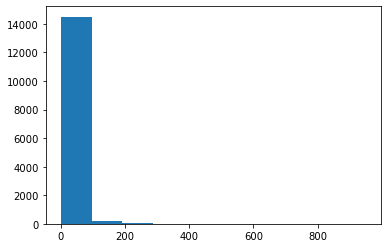

In [309]:
plt.hist([p[1] for p in adj_counts_per_noun])

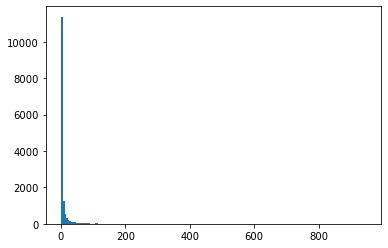

In [308]:
plt.hist([p[1] for p in adj_counts_per_noun], range(1, 951, 5))
plt.show()

#### Histogram of data with small adjective counts

In [293]:
small_counts = [p for p in adj_counts_per_noun if p[1] <= 10]

(array([6696., 2227., 1205.,  733.,  515.,  394.,  307.,  223.,  195.,
         130.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

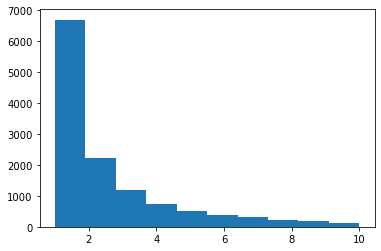

In [294]:
# is not really a histogram, because each bar is just the amount of nouns with that number of count (from 1 to 10),
# but it was good to bring it out separately, as a lot of nouns had been described by few adjectives
plt.hist([p[1] for p in small_counts])

#### Histogram of data with medium adjective counts

In [297]:
medium_counts = [p for p in adj_counts_per_noun if p[1] > 10 and p[1] < 100]

(array([450., 354., 225., 166., 136.,  94.,  79.,  64.,  68.,  40.,  43.,
         32.,  37.,  27.,  28.,  19.,  13.,  14.]),
 array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
         75,  80,  85,  90,  95, 100]),
 <BarContainer object of 18 artists>)

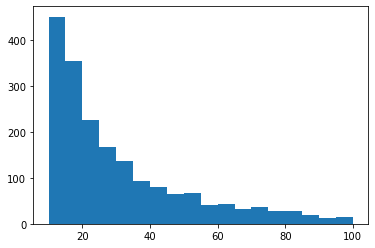

In [311]:
plt.hist([p[1] for p in medium_counts], range(10, 101, 5)) # step of 5, so bins are 11-14, 15-19, 20-24 and so on

(array([804., 357., 227., 144., 104.,  76.,  64.,  48.,  41.,  24.]),
 array([11. , 19.8, 28.6, 37.4, 46.2, 55. , 63.8, 72.6, 81.4, 90.2, 99. ]),
 <BarContainer object of 10 artists>)

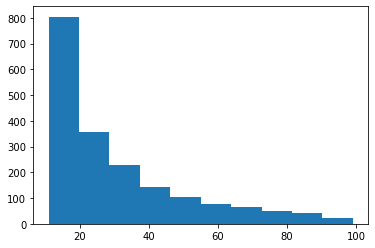

In [314]:
plt.hist([p[1] for p in medium_counts]) # default number of bins

#### Histogram of data with large adjective counts

In [299]:
large_counts = [p for p in adj_counts_per_noun if p[1] >= 100]

In [302]:
max([p[1] for p in large_counts])

950

(array([117.,  50.,  30.,  12.,   4.,   4.,   3.,   2.,   2.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
        750, 800, 850, 900, 950]),
 <BarContainer object of 17 artists>)

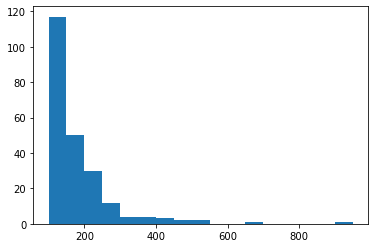

In [304]:
plt.hist([p[1] for p in large_counts], range(100, 1000, 50)) # step of 50